# 1. Loading and preparing dataset

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
import re

# 1) Start your Spark session (if not already running)
spark = SparkSession.builder.appName("LoadAllBeautyFromGCS").getOrCreate()

# 2) Define your GCS URIs
reviews_uri = "gs://mock-ic1/All_Beauty.jsonl"
meta_uri = "gs://mock-ic1/meta_All_Beauty.jsonl"

# 3) Read the reviews file (this seems to work fine)
df_user_review = spark.read.json(reviews_uri)

# 4) Loading item_metadata seperately 
raw_lines = spark.sparkContext.textFile(meta_uri)

def safe_parse_json(line):
    import json
    try:
        # Parse the JSON line
        data = json.loads(line)
        # Handle the problematic field if it exists
        if "assembly required" in data:
            data["assembly_required"] = data.pop("assembly required")
        return [json.dumps(data)]  # Return as a list for flatMap
    except:
        return []  # Skip corrupted lines

clean_json_rdd = raw_lines.flatMap(safe_parse_json)

# Convert back to a DataFrame
df_item_metadata = spark.read.json(clean_json_rdd)

# 5) Quick sanity check
print("\n=== Reviews Schema ===")
df_user_review.printSchema()
print("\n=== Meta Schema ===")
df_item_metadata.printSchema()

# Show sample data
print("\n=== Reviews Sample ===")
df_user_review.show(5, truncate=False)
print("\n=== Meta Sample ===")
df_item_metadata.show(5, truncate=False)

# 6) Count to verify data was loaded
print(f"\nReviews count: {df_user_review.count()}")
print(f"Metadata count: {df_item_metadata.count()}")

25/05/06 13:31:18 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/05/06 13:32:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



=== Reviews Schema ===
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)


=== Meta Schema ===
root
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true

+----------+------------+------+-----------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-----------------------------------------+----------------------------+-----------------+
|asin      |helpful_vote|images|parent_asin|rating|text                                                                                                                                                                                                                                                                                                        |timestamp    |title                                    |user_id                     |verified_purchase|
+----------+------------+------+-----------+------+-------------------------------------

+--------------+---------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Reviews count: 701528


Metadata count: 112590


---

# 2. ALS Model

## 2.1 Loading up data into ALS model

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, explode, split, regexp_replace
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

After loading the data we are creating a specific dataframe where we are going to store specific user_ids and their according asin and ratings for the products. Then we need to select the necessary columns for the ALS model which are the user_id, item_id and ultimately the rating which is helpiing us to understand by how much a user is likely to buy an item according to similar users. The rating goes from 0-10. Our main dataframe will be the so called als_df which is represented by the A matrix in the report. Moreover we are printing some statistics to get a better overview of what data we have at hand inside matrix A.

In [4]:
# 1. DATA PREPARATION
# Select relevant columns for the recommendation system
ratings_df = df_user_review.select("user_id", "asin", "rating")

# Convert the user_id (string) to a numeric index for ALS
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StringIndexer

# Create numeric user IDs
user_indexer = StringIndexer(inputCol="user_id", outputCol="userId_numeric", handleInvalid="skip")
user_indexed_model = user_indexer.fit(ratings_df)
ratings_df = user_indexed_model.transform(ratings_df)

# Create numeric item IDs
item_indexer = StringIndexer(inputCol="asin", outputCol="itemId_numeric", handleInvalid="skip")
item_indexed_model = item_indexer.fit(ratings_df)
ratings_df = item_indexed_model.transform(ratings_df)

# Select necessary columns for ALS model
als_df = ratings_df.select("user_id", "userId_numeric", "asin", "itemId_numeric", "rating")

# Verify data preparation
print("\nPrepared data sample:")
als_df.show(5, truncate = False)

# Check for any null values
print("\nNull values count:")
als_df.select([col(c).isNull().alias(c) for c in als_df.columns]).summary().show()

# Basic statistics for ratings
print("\nRatings statistics:")
als_df.describe("rating").show()

25/05/06 13:32:57 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB
25/05/06 13:33:08 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB



Prepared data sample:


25/05/06 13:33:13 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


+--------------------+--------------+----------+--------------+------+
|             user_id|userId_numeric|      asin|itemId_numeric|rating|
+--------------------+--------------+----------+--------------+------+
|AGKHLEW2SOWHNMFQI...|       33934.0|B00YQ6X8EO|         686.0|   5.0|
|AGKHLEW2SOWHNMFQI...|       33934.0|B081TJ8YS3|        9899.0|   4.0|
|AE74DYR3QUGVPZJ3P...|       71462.0|B07PNNCSP9|       14563.0|   5.0|
|AFQLNQNQYFWQZPJQZ...|       26005.0|B09JS339BZ|      112872.0|   1.0|
|AFQLNQNQYFWQZPJQZ...|       26005.0|B08BZ63GMJ|       43503.0|   5.0|
+--------------------+--------------+----------+--------------+------+
only showing top 5 rows


Null values count:
+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    25%|
|    50%|
|    75%|
|    max|
+-------+


Ratings statistics:


25/05/06 13:33:19 WARN DAGScheduler: Broadcasting large task binary with size 30.9 MiB


+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            701528|
|   mean|3.9602453501499584|
| stddev|1.4944515968822216|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



## 2.2 Splitting data

In order to train our ALS model and consequently evaluate it as well, we are splitting the A matrix into a training and testing part with a split of 80/20, where 80% of the data will be used for training the ALS model and 20% will not be shown to the model so that the weights for the X and Y matrix are not influenced by testing data. Therefore within the testing scenario the RMSE, root mean square error, will be assessed as the performance metric.

In [5]:
# 2. SPLIT DATA FOR TRAINING AND TESTING
# Split data into training and test sets
(training_data, test_data) = als_df.randomSplit([0.8, 0.2], seed=42)

# Cache the datasets for improved performance
training_data.cache()
test_data.cache()

print(f"Training data count: {training_data.count()}")
print(f"Test data count: {test_data.count()}")

25/05/06 13:33:29 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB
25/05/06 13:33:42 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


Training data count: 561122


25/05/06 13:33:46 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB
25/05/06 13:33:55 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB


Test data count: 140406


Quickly we will check how man RDD partitions have been created to handle this dataset.

In [6]:
# Getting the number of current RDD partitions
print('Number of partitions: ', training_data.rdd.getNumPartitions())

# Requesting the number of worker nodes assigned to master node
print('Number of workers:', sc._conf.get('spark.executor.instances'))

Number of partitions:  3
Number of workers: 2


## 2.3 Training ALS

Ultimately we train the ALS using the library from pyspark, and we predefine arbitarily the hyperparameters. We chose a quite low amount of latent features and a low amount of maximum iterations due to the aforementioned high likelihood of the kernel crashing while training. In order ot keep the size as low as possible, we reduced the dimensionality of the matrices by reducing the latent features to 3 instead holding them at 5 or 10, since the matrices X and Y are having their dimension set by k = latent features.

In [8]:
# 3. TRAIN ALS MODEL
# Initialize ALS model
als = ALS(
    rank=3,                      # Number of latent factors
    maxIter=5,                   # Maximum number of iterations
    regParam=0.1,                # Regularization parameter
    userCol="userId_numeric",    # User column name
    itemCol="itemId_numeric",    # Item column name
    ratingCol="rating",          # Rating column name
    coldStartStrategy="drop"     # Strategy to handle cold start problem    
).setCheckpointInterval(2)       # cut lineage every 2 iterations

In [9]:
# Train the model
model = als.fit(training_data)

25/05/06 13:34:34 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:34:39 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:34:43 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:34:48 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:01 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:05 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:14 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:22 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:29 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:37 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:44 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:35:51 WARN DAGScheduler: Broadc

## 2.4 Evaluating ALS

After our first ALS model has been trained we are evaluating the ALS model with our testing set using the performance metric root mean squared error, which is common when it comes to continous optimization methods.

In [ ]:
# 4. EVALUATE THE MODEL
# Make predictions on test data
predictions = model.transform(test_data)

# Evaluate model using RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating", 
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"\nRoot Mean Squared Error (RMSE): {rmse}")

---

# 3. Hyperparameter tuning

In order to improve our first ALS model performance in terms of the RMSE, we are going to apply hyperparameter tuning by using cross-validation. Here we are defining the paramter grid in order to explore the best combination of hyperparameters (latent factors = rank, maximum iterations, and the regualarization parameter lambda). At the end we are going to visualize and compare each of the models to make a decision which model to choose ultimately.

In [ ]:
# HYPERPARAMETER TUNING
from pyspark.ml.tuning import TrainValidationSplit

# Define parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [2, 4]) \
    .addGrid(als.maxIter, [2, 3]) \
    .addGrid(als.regParam, [0.1]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating", 
    predictionCol="prediction"
)

# Create train validation split which serves
tv = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8
).setParallelism(2)   # at most 2 models at once

In [ ]:
# HYPERPARAMETER TUNING

# Fit train validation model
tv_model = tv.fit(training_data)

# Get the best model
best_model = tv_model.bestModel

# Print best model parameters
print(f"\nBest model parameters:")
print(f"  Rank: {best_model.rank}")
print(f"  MaxIter: {best_model._java_obj.parent().getMaxIter()}")
print(f"  RegParam: {best_model._java_obj.parent().getRegParam()}")

25/05/06 13:37:07 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB
25/05/06 13:37:09 WARN DAGScheduler: Broadcasting large task binary with size 34.4 MiB
25/05/06 13:37:15 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:17 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:21 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:23 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:25 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:26 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:28 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:30 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:39 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 13:37:41 WARN DAGScheduler: Broadc


Best model parameters:
  Rank: 4
  MaxIter: 3
  RegParam: 0.1


In [ ]:
# Function to visualize RMSE for different hyperparameters
def visualize_hyperparameter_tuning(tv_model):
    # Extract parameters and RMSE from the TrainValidationSplit model
    params = tv_model.getEstimatorParamMaps()
    metrics = tv_model.validationMetrics
    
    # Convert to pandas DataFrame for easier plotting
    tuning_results = []
    for i, p in enumerate(params):
        rank = p[als.rank]
        max_iter = p[als.maxIter]
        reg_param = p[als.regParam]
        rmse = metrics[i]
        tuning_results.append((rank, max_iter, reg_param, rmse))
    
    tuning_df = pd.DataFrame(tuning_results, columns=["rank", "max_iter", "reg_param", "rmse"])
    
    # Plot RMSE for different rank values
    plt.figure(figsize=(12, 6))
    
    for max_iter in tuning_df["max_iter"].unique():
        for reg_param in tuning_df["reg_param"].unique():
            subset = tuning_df[(tuning_df["max_iter"] == max_iter) & (tuning_df["reg_param"] == reg_param)]
            plt.plot(subset["rank"], subset["rmse"], marker='o', 
                     label=f"maxIter={max_iter}, regParam={reg_param}")
    
    plt.title("RMSE by Rank, MaxIter, and RegParam")
    plt.xlabel("Rank")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

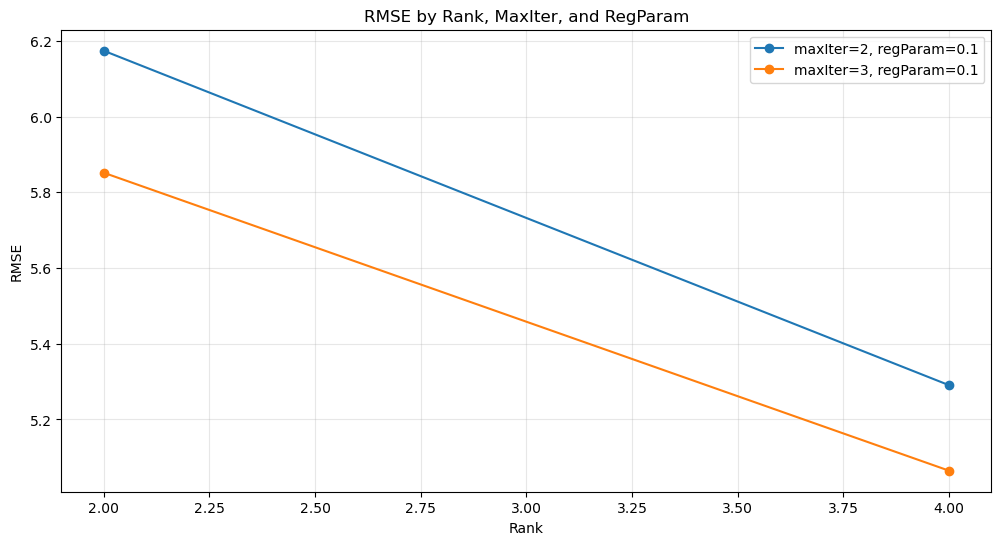

In [ ]:
# Visualize hyperparameter tuning results
visualize_hyperparameter_tuning(tv_model)

Due to multiple issues like crashing kernels (due to the size of the data) in GCP when training multiple models at once, we were not able to train for more parameters in order to get multiple model performances at once. However, this visualization already helps us in order to identify the correct directions of the hyperparatmers and how they should be changed in order to descrease the RMSE. Here we can see that increasing the rank as well as increasing the maximum amount of iterations helps to decrease the RMSE and thus improve the performance of the ALS.

---

# 4. Recommendations with ALS

Now we want to take 50 random users and generate recommendations for these users in order to compare the recommendation to the other LLM recommendation systems:

In [ ]:
from pyspark.sql.functions import rand

# create distinct users dataframe
#distinct_users = user_reviews.select("user_id").distinct()

# randomly order them and keep the first 50
#sampled_users = distinct_users.orderBy(rand()).limit(50)

In [16]:
# Loading sampled users from specific bucket in GCP
sampled_users = spark.read.option("header", "True").csv("gs://mock-ic1/sampled_users_200_part-00000-ef016e81-87ea-4682-a672-ae7d87b3635f-c000.csv")
sampled_users.show()

+--------------------+
|             user_id|
+--------------------+
|AHH3KONXXZKESASQJ...|
|AHX5BZ7MJLI65MT2N...|
|AEHMB75USBWCEXDUB...|
|AEKNDFPJ673UTWTQX...|
|AFOG6QTGCLS5ESC5V...|
|AG2NXZ4TRDARV6OH4...|
|AGJKI3W4H3JAQ5JK4...|
|AE7ALIJNPDQUGV6K3...|
|AHANTQAT4NJ7K44KR...|
|AEOFJHMGGVKQIOTGB...|
|AECMFDQUDRZRUZCC2...|
|AG5JN5W2W47V4AQ2J...|
|AGPIYKVWX73X5ANM2...|
|AEEEPQHXRKA73WV2W...|
|AEWYQDIVY3MKUBNOG...|
|AG4WZ7TBSJOR3RLSZ...|
|AF56LRBUQCMBWOBDS...|
|AEABLFPUF3MKKAZ34...|
|AFPLHNXH5ZRD253KZ...|
|AH7RFJZVI4P5ZVCP7...|
+--------------------+
only showing top 20 rows



In [17]:
# Creating a dataframe that has just the mapping between user_id and userId_numeric
user_id_mapping = als_df.select("user_id", "userId_numeric").distinct()

# Joining this mapping with the sampled_users dataframe
enriched_sampled_users = sampled_users.join(
    user_id_mapping,
    sampled_users["user_id"] == user_id_mapping["user_id"],
    "left"  # Using left join to keep all records in sampled_users, even if no match is found
)

# Verifying the results
print("Sample of enriched users:")
enriched_sampled_users.show(5, truncate=False)

# Count of rows before and after to check if join was successful
original_count = sampled_users.count()
new_count = enriched_sampled_users.count()
print(f"Original count: {original_count}, New count: {new_count}")

# Count how many users got a numeric ID successfully matched
matched_count = enriched_sampled_users.filter(enriched_sampled_users["userId_numeric"].isNotNull()).count()
print(f"Users with matched numeric IDs: {matched_count} ({matched_count/new_count*100:.2f}%)")

Sample of enriched users:


25/05/06 13:44:02 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_590_4 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_595_4 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_730_4 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_730_8 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_730_0 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_595_2 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_590_7 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_222_4 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_735_8 !
25/05/06 13:44:07 WARN BlockManagerMasterEndpoint: No more replicas

+----------------------------+----------------------------+--------------+
|user_id                     |user_id                     |userId_numeric|
+----------------------------+----------------------------+--------------+
|AEHMB75USBWCEXDUBZKS5XVC5MGQ|AEHMB75USBWCEXDUBZKS5XVC5MGQ|110289.0      |
|AG2NXZ4TRDARV6OH46RWU2H23YCA|AG2NXZ4TRDARV6OH46RWU2H23YCA|342661.0      |
|AHX5BZ7MJLI65MT2N7NB3PER3H3A|AHX5BZ7MJLI65MT2N7NB3PER3H3A|618936.0      |
|AEKNDFPJ673UTWTQXB25HXKA5OXQ|AEKNDFPJ673UTWTQXB25HXKA5OXQ|124220.0      |
|AFOG6QTGCLS5ESC5V7GJS4YSXW7Q|AFOG6QTGCLS5ESC5V7GJS4YSXW7Q|286812.0      |
+----------------------------+----------------------------+--------------+
only showing top 5 rows



25/05/06 13:44:30 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_222_7 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_595_1 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_735_7 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_590_2 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_590_9 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_80_2 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_67_0 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_222_3 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_595_6 !
25/05/06 13:44:30 WARN BlockManagerMasterEndpoint: No more replicas a

Original count: 50, New count: 50


25/05/06 13:44:52 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 13:44:53 WARN DAGScheduler: Broadcasting large task binary with size 27.2 MiB
25/05/06 13:45:04 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB


Users with matched numeric IDs: 50 (100.00%)



[Stage 331:============================>                            (1 + 1) / 2]



In [19]:
# GENERATE RECOMMENDATIONS
# Generate top 5 product recommendations for each user
user_recs = best_model.recommendForAllUsers(5)
print("\nSample user recommendations:")
user_recs.limit(3).show(truncate=False)

# Generate top 5 user recommendations for each product, only focusing on user receommendations for now
#product_recs = model.recommendForAllItems(5)
#print("\nSample product recommendations:")
#product_recs.limit(3).show(truncate=False)


Sample user recommendations:


25/05/06 13:49:13 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:05:44 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:09:55 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB


+--------------+---------------------------------------------------------------------------------------------------+
|userId_numeric|recommendations                                                                                    |
+--------------+---------------------------------------------------------------------------------------------------+
|1             |[{33179, 10.106205}, {65004, 8.117802}, {46584, 8.105159}, {45285, 8.095875}, {41460, 8.094967}]   |
|3             |[{41675, 8.196576}, {33459, 8.179665}, {45838, 8.14883}, {63812, 8.121707}, {60490, 8.119858}]     |
|4             |[{62081, 11.652048}, {52803, 11.01835}, {32967, 10.957702}, {25767, 10.862161}, {51010, 10.843661}]|
+--------------+---------------------------------------------------------------------------------------------------+



In [20]:
# Join enriched_sampled_users with user_recs to get the recommendations
# We join on the userId_numeric column which exists in both dataframes
users_with_recommendations = enriched_sampled_users.join(
    user_recs,
    enriched_sampled_users["userId_numeric"] == user_recs["userId_numeric"],
    "left"  # Using left join to keep all 50 users, even if some don't have recommendations
)

# Let's examine the result to ensure the join worked correctly
print("Sample of users with recommendations:")
users_with_recommendations.show(5, truncate=False)

Sample of users with recommendations:


25/05/06 14:13:13 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 14:13:14 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:13:24 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 14:13:53 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 14:25:27 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:25:47 WARN DAGScheduler: Broadcasting large task binary with size 34.6 MiB
25/05/06 14:25:49 WARN DAGScheduler: Broadcasting large task binary with size 34.6 MiB
25/05/06 14:25:51 WARN DAGScheduler: Broadcasting large task binary with size 34.6 MiB


+----------------------------+----------------------------+--------------+--------------+---------------------------------------------------------------------------------------------------+
|user_id                     |user_id                     |userId_numeric|userId_numeric|recommendations                                                                                    |
+----------------------------+----------------------------+--------------+--------------+---------------------------------------------------------------------------------------------------+
|AEHMB75USBWCEXDUBZKS5XVC5MGQ|AEHMB75USBWCEXDUBZKS5XVC5MGQ|110289.0      |110289        |[{64916, 9.651086}, {22351, 7.0687222}, {19548, 6.3430667}, {22088, 6.3246775}, {33038, 6.202521}] |
|AEKNDFPJ673UTWTQXB25HXKA5OXQ|AEKNDFPJ673UTWTQXB25HXKA5OXQ|124220.0      |124220        |[{33157, 22.188717}, {32744, 21.472721}, {13557, 19.062471}, {62081, 19.04678}, {19477, 18.62993}] |
|AFOG6QTGCLS5ESC5V7GJS4YSXW7Q|AFOG6QTGCLS5ESC5V7GJ

Now we want to generate specific product recommendations for a specifically chosen user (user_id: AEEOGN7VRJZEAGIGS3OZZDXS4YAQ) in order to compare our recommendations of the ALS model with the other recommendation systems.

In [ ]:
# Define the original user ID we're looking for
uid = "AEEOGN7VRJZEAGIGS3OZZDXS4YAQ"

# STEP 1: Find the numeric user ID for this specific user
# This creates a new dataframe containing just the row with our target user
target_user = als_df.filter(als_df["user_id"] == uid).select("user_id", "userId_numeric").distinct().limit(1)

# Display the user's information to confirm we found it
print("Target user information:")
target_user.show(truncate=False)

# Extract the userId_numeric value (we need this for the next step)
# We use collect() to bring the data to the driver and then access the first row's userId_numeric
try:
    # Get the user_numeric value
    user_numeric_value = target_user.collect()[0]["userId_numeric"]
    print(f"Found userId_numeric: {user_numeric_value}")
    
    # STEP 2: Get the recommendations for this user from user_recs
    # Filter the user_recs dataframe to find only this user's recommendations
    user_recommendations = user_recs.filter(user_recs["userId_numeric"] == user_numeric_value)
    
    # Display the recommendations to confirm we found them
    print("\nRecommendations for user ID:", uid)
    user_recommendations.show(truncate=False)
    
    
except IndexError:
    print(f"User ID {uid} not found in the dataset")

Target user information:


25/05/06 14:45:35 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 14:45:39 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB


+----------------------------+--------------+
|user_id                     |userId_numeric|
+----------------------------+--------------+
|AEEOGN7VRJZEAGIGS3OZZDXS4YAQ|97021.0       |
+----------------------------+--------------+



25/05/06 14:45:45 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB
25/05/06 14:45:49 WARN DAGScheduler: Broadcasting large task binary with size 33.9 MiB


Found userId_numeric: 97021.0

Recommendations for user ID: AEEOGN7VRJZEAGIGS3OZZDXS4YAQ


25/05/06 14:45:54 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:57:30 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:57:38 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB
25/05/06 14:57:49 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB


+--------------+--------------------------------------------------------------------------------------------------+
|userId_numeric|recommendations                                                                                   |
+--------------+--------------------------------------------------------------------------------------------------+
|97021         |[{64916, 9.883399}, {22351, 6.990704}, {22088, 6.9042945}, {33038, 6.5821137}, {19548, 6.2974095}]|
+--------------+--------------------------------------------------------------------------------------------------+



25/05/06 14:57:52 WARN DAGScheduler: Broadcasting large task binary with size 34.5 MiB


Here we can see the exact recommendations for the specific user we wanted to evaluate. The ALS gives us the top 5 product recommendations for our user with the itemId_numeric and the according rating (0 to 10 rating scale). Here we can see that the product 64916 is having a rating of approximately 9.88 and thus is very likely to be bought or liked by the user, based on the comparison of his preferences to similar customers having the same preferences. Therefore, Amazon now could be able to propose this specific item (with its itemId_numeric = asin) to the specific user, which would ultiamtely lead to more sales and higher revenue for the Amazon sales team - as the likelihood of buying items is significantly increased.

---